In [1]:
import dicom2nifti
import os
import nibabel as nib
import nilearn as nil
from nilearn import plotting
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np

# Neuroimaging Analysis Replication and Prediction Study 

## DISCLAIMER
> **This is an exploratory work on neuroimaging and variability for discussion and brainstorming, I am not a domain expert**

## Vocab
- MRI magnetic resonance imaging [https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FslOverview]
    - Functional (over time, low res, to study brain activity)
    - Structural (anatomical, high res instant shot, to study brain structure)

      
- Run : A run is an iteration of a subject data acquisition. Typically each subject has been tested 4 times, that is 4 run by subject with 4 batches of brain images and metadata (questions / answers)


## NARPS [https://www.biorxiv.org/content/10.1101/843193v1]

- Functional neuroimaging study (using MRI)
- 108 participants with a gambling test (money loss / gain with oral questions)
- 70 expert teams were given a single dataset with 9 hypothesis to tackle (hypothesis are anatomical, not mainstream)

## ISSUE
**None of the hypothesis was consensual over the 70 teams**

## Data
**Data gathering was performed at Tel Aviv University under control to miminize variability** [https://openneuro.org/datasets/ds001734/versions/1.0.5]
> 4D images (3D brain scans in time dimension) in nifti format [https://openneuro.org/datasets/ds001734/versions/1.0.5/download]. Includes meta data [https://nifti.nimh.nih.gov/nifti-1/]

> Data is somehow analogous to brain video if one wills, but captured using magnetic device, not optical.

> Basically data consists of brain images floating in a box.

### Here's a sample

In [2]:
brain_vol = nib.load('sub-001/func/sub-001_task-MGT_run-01_bold.nii.gz')

# What is the type of this object?
type(brain_vol)

nibabel.nifti1.Nifti1Image

### Nifti Header (Lot of information, and uncertainty) 

In [3]:
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'cmrr_mbep2d_bold'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [  4 106 106  64 453   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.0000000e+00  2.0000000e+00  2.0000000e+00  2.4000001e+00
  1.0000000e+00  1.0000000e+00  2.7500254e-01  5.9106805e+04]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 63
slice_code      : alternating increasing 2
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 29.150269
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b'TE=30;sec=59106.8050;phaseDir=+;dwell=0.275'
aux_file        : b'Unaliased MB4/PE4/LB'
qform_code      : scanner
sform_co

In [4]:
brain_vol_data = brain_vol.get_fdata()
brain_vol_data.shape

(106, 106, 64, 453)

> x,y = 106 pixels, z = 64 pixels
> 
> Sequence = 453 voxels of x.y.z dimensions

# Raw image (plain python matplotlib) of the 1st run of a subject in the dataset
1. > 31st 2D Slice of the 300th voxel in the sequence (Transversal plane, facing up)

2. > 52st 2D Slice of the 300th voxel in the sequence (Sagittal plane, facing right)

3. >  52st 2D Slice of the 300th voxel in the sequence (Coronal plane, facing forward)

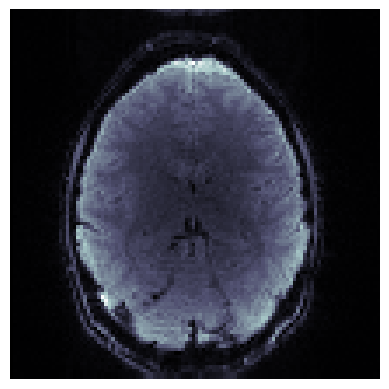

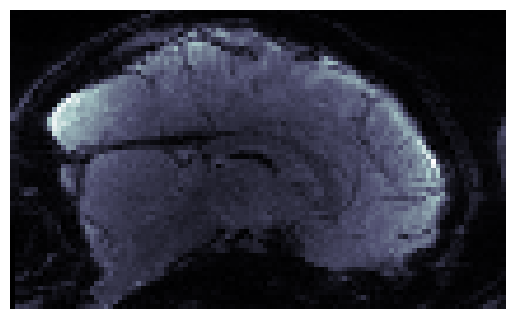

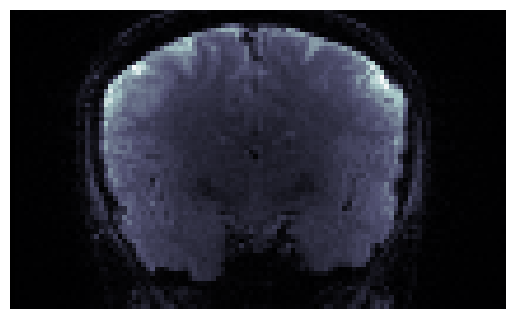

In [5]:

plt.imshow(np.rot90(brain_vol_data[:,:,31,300]),cmap='bone')
plt.axis('off')
plt.show()
plt.imshow(np.rot90(brain_vol_data[52,:,:,300]),cmap='bone')
plt.axis('off')
plt.show()
plt.imshow(np.rot90(brain_vol_data[:,52,:,300]),cmap='bone')
plt.axis('off')
plt.show()

### 3D plotting using nilearn of the 300th voxel
> Same coordinates, same planes order

> Very convenient

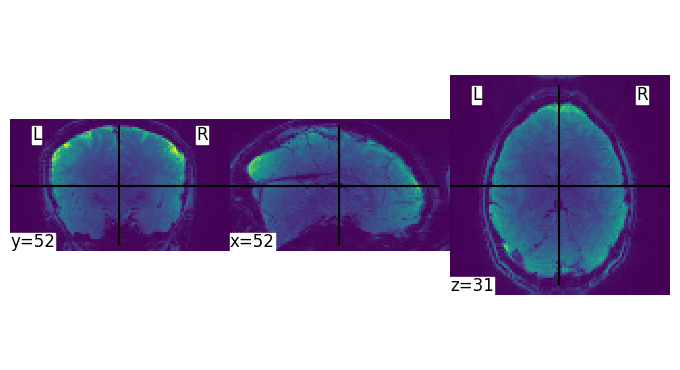

In [6]:
test_img=nib.Nifti1Image(brain_vol_data[:,:,:,300],np.eye(4))

plotting.plot_img(test_img,cut_coords=(52,52,31))

## Methods

### Description (as described in [https://www.biorxiv.org/content/10.1101/843193v1])
- Each image used to test an hypothesis is a 3D Nifti image.
- (not sure) This image is the average of a sample of (max) 54 subjects processed images X 4 runs per subject, related to hypothesis.

## Semantic
- Each subject's 4D data is bound to an events table (tsv). Each event is timed, in relation with a question asked by the operator and the subject's answer.
 
 ### Data Preprocessing
**Preprocessed data is around 550GB and raw data 300GB**


  
**The preprocessing consists of applying filters and segmenting the data to extract the brain images from their boxes with brain morphing (c.f raw pictures with box-shaped brains).**
 
 > Teams were allowed either to :
 1. Use fMRIPrep pre-processed data (global tool that does simple preprocessing)
 2. Create ad-Hoc pre-processing of data

> FMRI Prepreocessed data NiLearn plotting (comparison with raw data)

In [7]:
from nilearn import image
preproc_imgs='/Users/michel/workspace/narps_open_pipelines/data/original/ds001734/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'

preproc_imgs = nib.load(preproc_imgs)

preproc_img = image.index_img(preproc_imgs, 300)

{'raw_shape':test_img.get_fdata().shape, 'fmriprep_shape':preproc_img.get_fdata().shape
}

{'raw_shape': (106, 106, 64), 'fmriprep_shape': (97, 115, 81)}

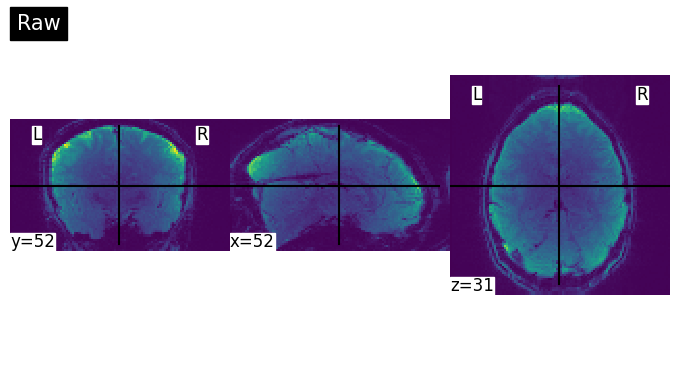

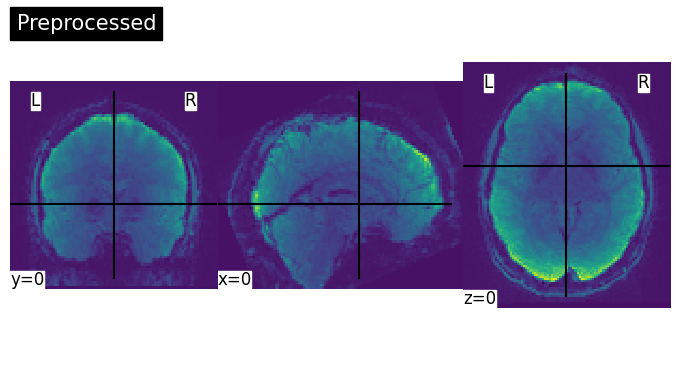

In [8]:

plotting.plot_img(test_img,cut_coords=(52,52,31),title="Raw")

plotting.plot_img(preproc_img,cut_coords=(0,0,0),title='Preprocessed')


 ### Output data
  > Output data consists of a model of 3D brain images through time with visualisation of blood pressure variation (pos. and neg. activation). The representation of the blood variation is based on colour mapped to brain regions and totally relies on the pipeline created by each team.

![alt text](brain.png)

  > Output data for a single subject can consist of as many individual models as there are runs (i.e 4 models per subject). Or a single model that spans all the runs at once (i.e A single model averaging 4 runs)



### Variability in methods
1. Subjects sampling for each hypothesis (up to 54 subjets over 108 grand total)

2. A wide variety of software for neuroimages manipulation.
 
   > **SPM** (matlab), **FSL** (C++), **AFNI** (C,Python,R), ...

3. Each software and technos that support it can vary in version
   
4. Complex processes to produce interpretable data from FMRI data

5. Many methods available to compare N-dimensional data (cos. similarity, dice-sorrenson, flattened vectorial distance, ...) 

# Variability handling options (Non-exhaustive list)
4. NiPype allows the creation of neuroimaging workflows, interfacing domain expert software [https://github.com/nipy/nipype]

![alt text](nypipe.webp)

5. Neurodocker allows the creation of environnement with full control on dependencies [https://hub.docker.com/r/repronim/neurodocker]
   
![alt text](B.png)
![alt text](A.png)
![alt text](C.png)

# Variability issues (Non-exhaustive functional aspect)
1. Experts have their own biases and habits
2. Some legacy software might be still in use even if deprecated
3. New functionalities of software might be unused

# What is done
## Narps_open_pipelines [https://github.com/Inria-Empenn/narps_open_pipelines]
> A repo being built by Neuroimaging Empenn team in Rennes

This work consists of reproducing the teams workflows using NiPype and try to replicate the results (available here [https://zenodo.org/record/3528329/files/narps_origdata_1.0.tgz])

**Reproducing workflows is a harsh task**
> At the moment we are struggling to get a pipeline running on our devices


# RQ 1
> Does the variation of software versions impact replicability of results ?
# RQ 2
> Is it possible to quantify resp. expert biases (processing choices and subsequent software parameterization) and software versions variation impact on results variability ?

# Next
## 1st naive approach
1. Manage to run a workflow reproduced in narps_open_pipelines
2. Make versions of domain expert software vary (using neurodocker)
3. Observe the results

## 2nd naive approach
1. Take a working worflow and make parameters vary
2. Observe the results
   